to do:
    
-write upscaling function 


In [40]:
from climada.util.api_client import Client
from climada.util.constants import RIVER_FLOOD_REGIONS_CSV
from climada_petals.entity.impact_funcs.river_flood import ImpfRiverFlood,flood_imp_func_set
import pandas as pd
from climada.engine import Impact
from climada.hazard import Hazard
import numpy as np
from climada.util import yearsets
import os
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from climada.util.multi_hazard import *
import datetime



countries = ['USA','TWN', 'HTI', 'MDG','COL', 'AUS', 'VNM', 'ITA']
def open_impacts(country, csv, impact_mat):
    try:
        impact = Impact.from_csv(csv)
        impact.imp_mat = impact.read_sparse_csr(impact_mat)
        return impact
    except:
        print("".join([" No data for ", str(country)]))
        return(None)

impact_csvs = {}
impact_mats = {}
impact_csvs_crops = {}
impact_mats_crops = {}
data_dir = '/Users/szelie/OneDrive - ETH Zurich/20211208_Multi-Impact_ZelieCarmen'
for country in countries:
    impact_csvs[country] = {}
    impact_mats[country] = {}
    impact_csvs_crops[country] = {}
    impact_mats_crops[country] = {}
    impact_csvs[country]['RF'] = os.path.join(data_dir, "".join(['RF_impact_mat/river_flood_impact_150arcsec_rcp60_2030_2050_',country,'.csv']))
    impact_mats[country]['RF'] = os.path.join(data_dir, "".join(['RF_impact_mat/river_flood_impact_150arcsec_rcp60_2030_2050_',country,'.npz']))


    #crops
    for crop in ['mai','ric','soy','whe']:
        impact_csvs_crops[country][crop] = os.path.join(data_dir, "".join(['CP_impact/ISIMIP2b/Impact_save_mat/imp_',country,'_',crop,'_rcp60_tonnes.csv']))
        impact_mats_crops[country][crop] = os.path.join(data_dir, "".join(['CP_impact/ISIMIP2b/Impact_save_mat/imp_mat_',country,'_',crop,'_rcp60_tonnes.npz']))

    #landslide


    

In [55]:
years = np.array(range(1,401))
hazard='RF'

impacts = {country:{hazard: open_impacts(country, impact_csvs[country][hazard], 
                                                  impact_mats[country][hazard]) for hazard in impact_csvs[country]} for country in impact_csvs}
impacts_yearsets = {country:{hazard: make_yearset(impacts[country][hazard], years) for hazard in impacts[country] if impacts[country][hazard]!=None} for country in impacts}

impacts_crops = {}
impact_crops_combined = {}
for country in impact_csvs_crops:
    impacts_crops[country] = {}
    for crop in impact_csvs_crops[country]:
        impact = Impact.from_csv(impact_csvs_crops[country][crop])
        impact.imp_mat = impact.read_sparse_csr(impact_mats_crops[country][crop])
        impacts_crops[country][crop] = impact
        impacts_list = list(impacts_crops[country].values())
        impact_crops_combined[country] = combine_yearly_impacts(impacts_list)
        impact_crops_combined[country] = impact_crops_combined[country].set_imp_mat(sp.sparse.csr_matrix(impact_crops_combined[country].imp_mat))

        impact_crops_combined[country] = impact_crops_combined[country].select(dates=(datetime.date.toordinal(datetime.date(2030, 1, 1)),datetime.date.toordinal(datetime.date(2050, 1, 1))))
        impact_crops_combined[country].frequency = np.ones(len(impact_crops_combined[country].event_id))/len(impact_crops_combined[country].event_id)
for country in impact_crops_combined:
    impacts[country]['CP'] = impact_crops_combined[country]
    impacts_yearsets[country]['CP'] = make_yearset(impact_crops_combined[country], years)
    

/Users/szelie/python_projects/climada_python/climada/engine/impact.py:812: DtypeWarning: Columns (0,1,2,3,7,14) have mixed types. Specify dtype option on import or set low_memory=False.
  imp_df = pd.read_csv(file_name)
/Users/szelie/python_projects/climada_python/climada/engine/impact.py:812: DtypeWarning: Columns (0,1,2,3,7,14) have mixed types. Specify dtype option on import or set low_memory=False.
  imp_df = pd.read_csv(file_name)


In [212]:
impacts_yearsets_ordered

{'USA': {'RF': <climada.engine.impact.Impact at 0x7fabe5fc6670>,
  'CP': <climada.engine.impact.Impact at 0x7fabe59bd0a0>,
  'TC': <climada.engine.impact.Impact at 0x7fabe60bf5e0>},
 'TWN': {'RF': <climada.engine.impact.Impact at 0x7fabe3e1da60>,
  'CP': <climada.engine.impact.Impact at 0x7fabe3e1d0a0>,
  'TC': <climada.engine.impact.Impact at 0x7fabe3e1d2b0>},
 'HTI': {'RF': <climada.engine.impact.Impact at 0x7fabe60bfe20>,
  'CP': <climada.engine.impact.Impact at 0x7fabe60bf9a0>,
  'TC': <climada.engine.impact.Impact at 0x7fabe60bf700>},
 'MDG': {'RF': <climada.engine.impact.Impact at 0x7fabe3e1dfa0>,
  'CP': <climada.engine.impact.Impact at 0x7fabe3e1dc70>,
  'TC': <climada.engine.impact.Impact at 0x7fabe3e1d430>},
 'COL': {'RF': <climada.engine.impact.Impact at 0x7fabe60bf6d0>,
  'CP': <climada.engine.impact.Impact at 0x7fabe3e1d0d0>,
  'TC': <climada.engine.impact.Impact at 0x7fabe3e1d640>},
 'AUS': {'RF': <climada.engine.impact.Impact at 0x7fad53042160>,
  'CP': <climada.engine.i

In [63]:
climate_models = ['miroc5','ipsl-cm5a-lr','gfdl-esm2m','hadgem2-es']
years = np.arange(2030,2050)
impacts_yearsets_ordered = {country: make_consistent_drivers_yearsets(impacts[country], 4, list_climate_models=climate_models, list_years=years) for country in countries}

In [60]:
corr_matrices = {country: make_correlation_matrix(impacts_yearsets[country]) for country in impacts_yearsets_ordered}
corr_matrices_ordered = {country: make_correlation_matrix(impacts_yearsets_ordered[country]) for country in impacts_yearsets_ordered}

In [59]:
impacts_yearsets_ordered[country]['CP'].aai_agg

904428.9326826229

In [74]:
corr_matrices_ordered['VNM']

,RF,CP
RF,1.000000,-0.034651
CP,-0.034651,1.000000


In [396]:
climate_models = ['miroc5','ipsl-cm5a-lr','gfdl-esm2m','hadgem2-es']
years = np.arange(2030,2050)

<AxesSubplot:title={'center':'Exceedance frequency curve'}, xlabel='Return period (year)', ylabel='Impact (t/y)'>

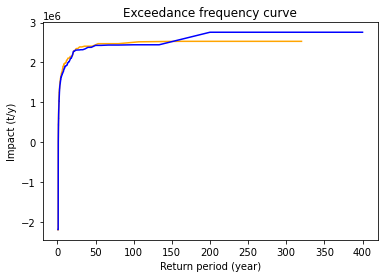

In [120]:
fig,ax = plt.subplots()
impacts_yearsets_ordered[country]['CP'].calc_freq_curve().plot(axis=ax,color='orange')
impacts_yearsets[country]['CP'].calc_freq_curve().plot(axis=ax, color='Blue')

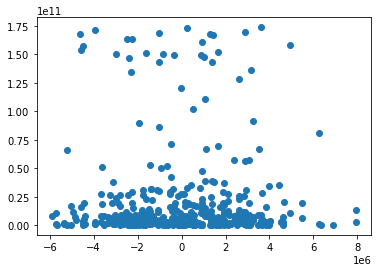

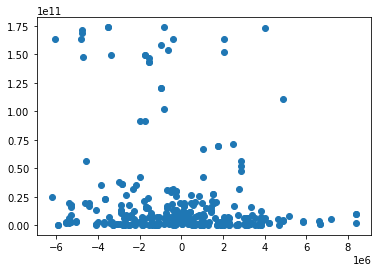

In [124]:
country = 'VNM'
fig,ax = plt.subplots()


ax.scatter(impacts_yearsets[country]['CP'].at_event,impacts_yearsets[country]['RF'].at_event)

fig,ax = plt.subplots()

ax.scatter(impacts_yearsets_ordered[country]['CP'].at_event,impacts_yearsets_ordered[country]['RF'].at_event)



In [130]:
path_windfields = '/Users/szelie/OneDrive - ETH Zurich/data/windfields/Trial1_GB_dkgfdl_rcp60cal_N_0360as.mat'

In [131]:
from climada.hazard.trop_cyclone import TropCyclone

In [132]:
tc = TropCyclone.from_mat(path_windfields)

In [133]:
tc_list = []
models_list = []
year_start = 2030
year_end = 2050
event_name_list = []
climate_models = ['miroc','ipsl','gfdl','had']
model_full_name = {'miroc':'miroc5','ipsl':'ipsl-cm5a-lr','gfdl':'gfdl-esm2m','had':'hadgem2-es'}
for n,model in enumerate(climate_models):
    path_windfields = "".join(['/Users/szelie/OneDrive - ETH Zurich/data/windfields/Trial1_GB_dk',model,'_rcp60cal_S_0360as.mat'])
    tc_south = TropCyclone.from_mat(path_windfields)
    path_windfields = "".join(['/Users/szelie/OneDrive - ETH Zurich/data/windfields/Trial1_GB_dk',model,'_rcp60cal_N_0360as.mat'])
    tc_north = TropCyclone.from_mat(path_windfields)
    tc = Hazard.concat([tc_south,tc_north])
    tc = tc.select(date=(datetime.date.toordinal(datetime.date(year_start, 1, 1)),datetime.date.toordinal(datetime.date(year_end, 1, 1))))
    event_name = ["".join([str( datetime.date.fromordinal(np.min(date)).year), '_', model_full_name[model]]) for date in tc.date]
    tc.frequency = np.ones(len(event_name))/(year_end - year_start)/len(climate_models)
    tc_list.append(tc)
    event_name_list.append(event_name)
tc = TropCyclone.concat(tc_list) 
tc.event_name = np.concatenate(event_name_list)

In [136]:
tc.centroids.set_region_id()

/Users/szelie/python_projects/climada_python/climada/util/coordinates.py:1372: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  countries['area'] = countries.geometry.area


In [213]:
from climada.util.api_client import Client
client = Client()
exp_dict = {}
countries = ['USA','TWN', 'HTI', 'MDG','COL', 'AUS', 'VNM', 'ITA']
for country in countries:
    exp_dict[country] = client.get_litpop_default(country)
    #exp_dict[country].assign_centroids(tc)


In [138]:
from climada.entity.impact_funcs.trop_cyclone import ImpfSetTropCyclone
impf_TC = ImpfSetTropCyclone.from_calibrated_regional_ImpfSet()
def get_id(cnt):
    for basin, iso_list in impf_TC.get_countries_per_region()[3].items():
        for iso in iso_list:
            if iso == cnt:
                return basin, impf_TC.get_countries_per_region()[1][basin]
for cnt, exp in exp_dict.items():
    impf_id = get_id(cnt)[1]
    exp.gdf['impf_TC'] = impf_id

In [145]:
countries

['USA', 'TWN', 'HTI', 'MDG', 'COL', 'AUS', 'VNM']

In [146]:
import pycountry
country='TWN'
years = np.arange(2030,2050)
impacts_yearsets_kerry = {}
impacts_yearsets_knutsen = {}
for country in countries:
    tc_country = tc.select(reg_id=int(pycountry.countries.get(alpha_3=country).numeric))
    impacts_yearsets_kerry[country] = {}
    impacts_yearsets_knutsen[country] = {}
    tc_knutsen = client.get_hazard('tropical_cyclone', properties={'country_iso3alpha': country, 'climate_scenario':'rcp26',  'nb_synth_tracks':'10', 'ref_year':'2040'})
    imp_kerry = Impact()
    exp_dict[country].assign_centroids(tc_country)
    imp_knutsen = Impact()
    imp_kerry.calc(exp_dict[country], impf_TC, tc_country, save_mat=True)
    exp_dict[country].assign_centroids(tc_knutsen)
    imp_knutsen.calc(exp_dict[country], impf_TC, tc_knutsen, save_mat=True)
    impacts[country]['TC'] = aggregate_impact_from_event_name(imp_kerry, exp_dict[country])
    years_yearsets = np.array(range(1,401))
    impacts_yearsets[country]['TC'] = make_yearset(impacts[country]['TC'], years_yearsets, exposures=exp_dict[country])
    impacts_yearsets_knutsen[country]['TC'] = make_yearset(imp_knutsen, years_yearsets, exposures=exp_dict[country])


climate_models = ['miroc5','ipsl-cm5a-lr','gfdl-esm2m','hadgem2-es']
#impacts_yearsets_ordered = {country: {hazard: [order_climate_driver(impacts_yearsets[country][hazard][0], climate_models, years)] for hazard in impacts_yearsets[country]} for country in countries}
#impacts_yearsets_ordered_kerry = {country: {'TC': [order_climate_driver(impacts_yearsets_kerry[country]['TC'][0], climate_models, years)]} for country in countries}



2022-05-04 10:07:57,595 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 79 coordinates.
2022-05-04 10:07:57,617 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 1 coordinates.
2022-05-04 10:07:59,031 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 129752 coordinates.


/Users/szelie/miniconda3/envs/climada_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/Users/szelie/miniconda3/envs/climada_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/Users/szelie/miniconda3/envs/climada_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-o

2022-05-04 10:08:54,348 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 1 coordinates.
2022-05-04 10:08:54,433 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 1 coordinates.


/Users/szelie/miniconda3/envs/climada_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size


2022-05-04 10:09:04,714 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 10 coordinates.
2022-05-04 10:09:08,492 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 10 coordinates.


/Users/szelie/miniconda3/envs/climada_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/Users/szelie/miniconda3/envs/climada_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size


In [216]:
impacts_yearsets_ordered = {country: make_consistent_drivers_yearsets(impacts[country], 4, list_climate_models=climate_models, list_years=years) for country in countries}

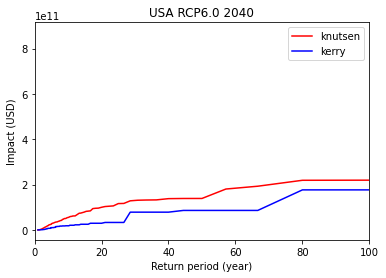

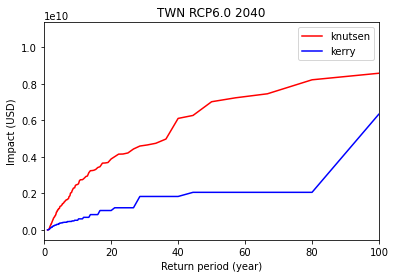

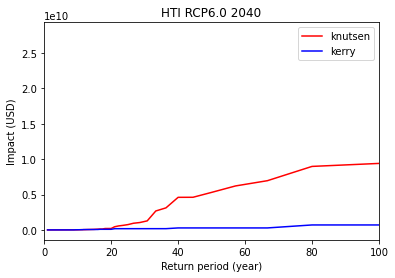

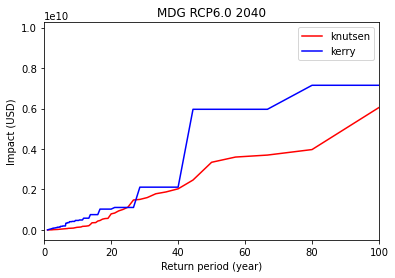

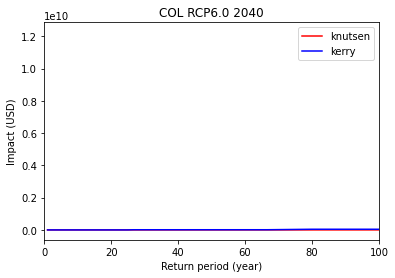

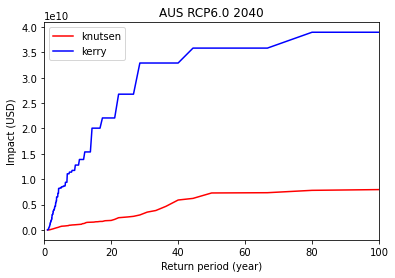

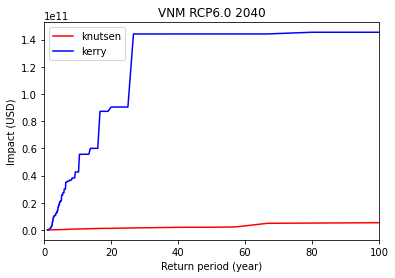

In [148]:
for country in countries:

    fig,ax = plt.subplots()

    #impacts_yearsets_kerry[country]['TC'][0].calc_freq_curve().plot(axis=ax,color='orange')
    impacts_yearsets_knutsen[country]['TC'].calc_freq_curve().plot(axis=ax,color='red', label='knutsen')
    impacts_yearsets[country]['TC'].calc_freq_curve().plot(axis=ax,color='blue', label='kerry')
    ax.set_title(country +' RCP6.0 2040')
    ax.legend()
    ax.set_xlim(0,100)

In [243]:
corr_matrices = {country: make_correlation_matrix(impacts_yearsets[country]) for country in impacts_yearsets_ordered}
corr_matrices_ordered = {country: make_correlation_matrix(impacts_yearsets_ordered[country]) for country in impacts_yearsets_ordered}

In [245]:
corr_matrices_ordered['ITA']

,RF,CP
RF,1.000000,0.079841
CP,0.079841,1.000000


In [257]:
[i for i in np.ndenumerate(corr_matrices_ordered['VNM'].to_numpy())]

[((0, 0), 1.0),
 ((0, 1), -0.2137380852171951),
 ((0, 2), -0.12027063250859665),
 ((1, 0), -0.2137380852171951),
 ((1, 1), 1.0),
 ((1, 2), 0.12438512537522561),
 ((2, 0), -0.12027063250859665),
 ((2, 1), 0.12438512537522561),
 ((2, 2), 1.0)]

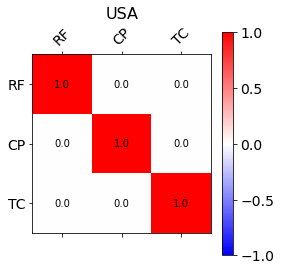

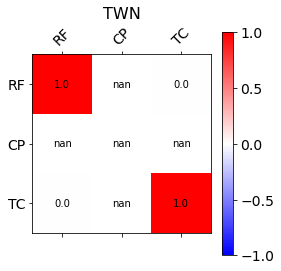

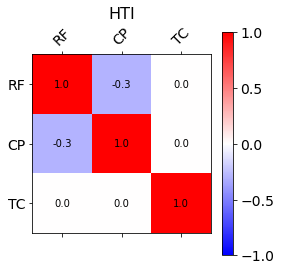

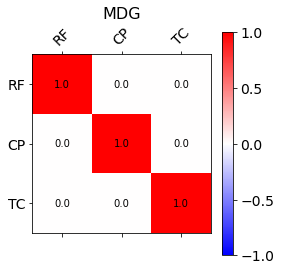

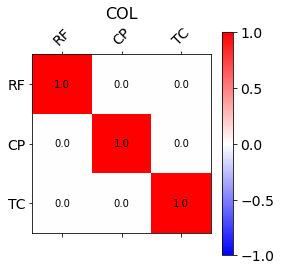

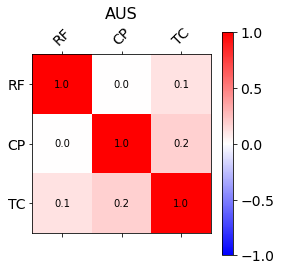

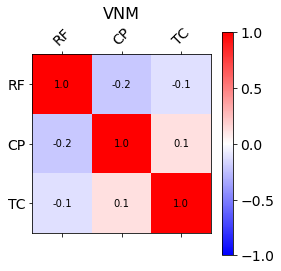

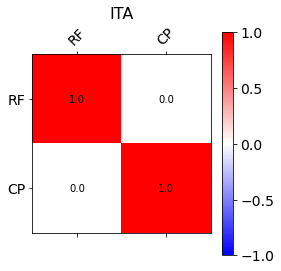

In [259]:
import matplotlib.colors as mcolors

for country in corr_matrices_ordered:
    df = corr_matrices_ordered[country].copy()
    df[(df<0.1)&(df>-0.1)] = 0
    norm = mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
    plt.matshow(df, cmap='bwr',norm=norm)
    plt.xticks(ticks=range(len(df.columns)),labels=np.array(df.index), fontsize=14, rotation=45)
    plt.yticks(ticks=range(len(df.columns)),labels=np.array(df.index), fontsize=14)
    
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title(country, fontsize=16)
    for (i, j), z in np.ndenumerate(df):
        plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')


In [262]:
impacts_yearsets_ordered

{'USA': {'RF': <climada.engine.impact.Impact at 0x7fad5077cf10>,
  'CP': <climada.engine.impact.Impact at 0x7fab50301c40>,
  'TC': <climada.engine.impact.Impact at 0x7fad53aec070>},
 'TWN': {'RF': <climada.engine.impact.Impact at 0x7fabe503e8b0>,
  'CP': <climada.engine.impact.Impact at 0x7fabe503ea00>,
  'TC': <climada.engine.impact.Impact at 0x7fabe503eac0>},
 'HTI': {'RF': <climada.engine.impact.Impact at 0x7fabe503e9d0>,
  'CP': <climada.engine.impact.Impact at 0x7fabe503eb50>,
  'TC': <climada.engine.impact.Impact at 0x7fabe503ec10>},
 'MDG': {'RF': <climada.engine.impact.Impact at 0x7fabe503ed30>,
  'CP': <climada.engine.impact.Impact at 0x7fabe503ee80>,
  'TC': <climada.engine.impact.Impact at 0x7fabe503eeb0>},
 'COL': {'RF': <climada.engine.impact.Impact at 0x7fabe503efd0>,
  'CP': <climada.engine.impact.Impact at 0x7fabe503ea30>,
  'TC': <climada.engine.impact.Impact at 0x7fabe503e820>},
 'AUS': {'RF': <climada.engine.impact.Impact at 0x7fadb7af3160>,
  'CP': <climada.engine.i

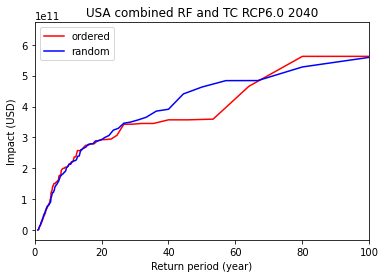

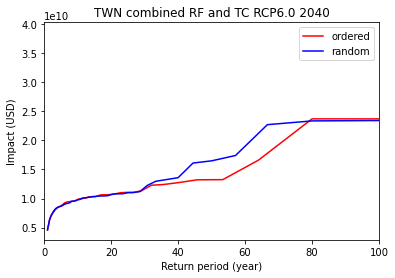

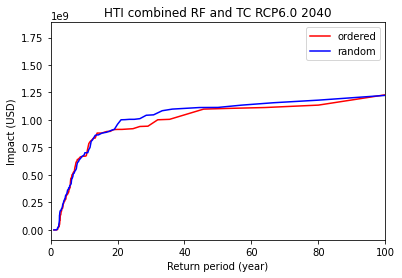

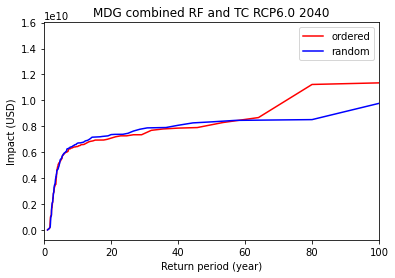

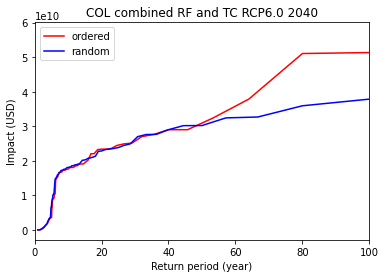

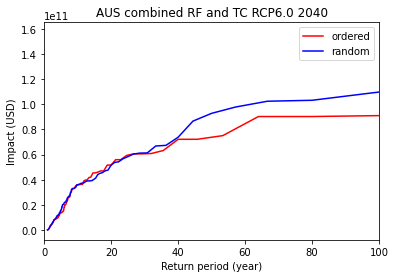

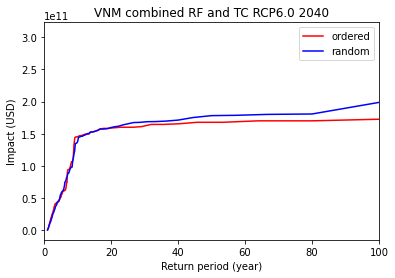

In [270]:
for country in countries:
    if country!='ITA':
        combined_impact_ordered = combine_yearly_impacts([impacts_yearsets_ordered[country]['TC'], impacts_yearsets_ordered[country]['RF']])
        combined_impact = combine_yearly_impacts([impacts_yearsets[country]['TC'], impacts_yearsets[country]['RF']])

        fig,ax = plt.subplots()

        #impacts_yearsets_kerry[country]['TC'][0].calc_freq_curve().plot(axis=ax,color='orange')
        combined_impact_ordered.calc_freq_curve().plot(axis=ax,color='red', label='ordered')
        combined_impact.calc_freq_curve().plot(axis=ax,color='blue', label='random')
        ax.set_title(country +' combined RF and TC RCP6.0 2040')
        ax.legend()
        ax.set_xlim(0,100)